# Explore here

# Organización de rutas

In [14]:
import os
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpointimport zipfile

# Rutas de datos
PATH_RAW = "/workspace/deep-learning/data/raw"
PATH_INTERIM = "/workspace/deep-learning/data/interim"
PATH_PROCESSED = "/workspace/deep-learning/data/processed"

# Ruta del archivo ZIP
ZIP_FILE = os.path.join(PATH_RAW, "train.zip")

# Descomprimir archivo ZIP
os.makedirs(PATH_INTERIM, exist_ok=True)

if not os.path.isfile(ZIP_FILE):
    raise FileNotFoundError(f"El archivo ZIP no se encuentra en {ZIP_FILE}.")

with zipfile.ZipFile(ZIP_FILE, 'r') as z:
    z.extractall(PATH_INTERIM)
print(f"Archivo {ZIP_FILE} descomprimido en {PATH_INTERIM}.")



Archivo /workspace/deep-learning/data/raw/train.zip descomprimido en /workspace/deep-learning/data/interim.


# Filtrar y dividir

In [30]:
import os
from sklearn.model_selection import train_test_split

# Ruta de las imágenes 
interim_path = "/workspace/deep-learning/data/interim/train"
all_images = os.listdir(interim_path)

# Filtrar imágenes de perros y gatos
dog_images = [img for img in all_images if "dog" in img]
cat_images = [img for img in all_images if "cat" in img]

# Verificar contenido
print(f"Total de imágenes: {len(all_images)}")
print(f"Imágenes de perros: {len(dog_images)}")
print(f"Imágenes de gatos: {len(cat_images)}")

# Dividir en conjuntos de entrenamiento y validación
if len(dog_images) > 1:
    train_dogs, val_dogs = train_test_split(dog_images, test_size=0.2, random_state=42)
else:
    train_dogs, val_dogs = dog_images, []

if len(cat_images) > 1:
    train_cats, val_cats = train_test_split(cat_images, test_size=0.2, random_state=42)
else:
    train_cats, val_cats = cat_images, []

print(f"Perros - Entrenamiento: {len(train_dogs)}, Validación: {len(val_dogs)}")
print(f"Gatos - Entrenamiento: {len(train_cats)}, Validación: {len(val_cats)}")



Total de imágenes: 2000
Imágenes de perros: 1000
Imágenes de gatos: 1000
Perros - Entrenamiento: 800, Validación: 200
Gatos - Entrenamiento: 800, Validación: 200


# Organización de Imágenes

In [ ]:
import os
import shutil

# Rutas para datos
train_dir = os.path.join(PATH_PROCESSED, "train")
val_dir = os.path.join(PATH_PROCESSED, "val")

# Crear carpetas para entrenamiento y validación
for category in ['train', 'val']:
    for label in ['dog', 'cat']:
        os.makedirs(os.path.join(PATH_PROCESSED, category, label), exist_ok=True)

# Función para mover imágenes
def move_files(file_list, source_dir, target_dir):
    for file_name in file_list:
        src_path = os.path.join(source_dir, file_name)
        dst_path = os.path.join(target_dir, file_name)
        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)

# Mover imágenes de entrenamiento y validación
move_files(train_dogs, interim_path, os.path.join(train_dir, "dog"))
move_files(val_dogs, interim_path, os.path.join(val_dir, "dog"))
move_files(train_cats, interim_path, os.path.join(train_dir, "cat"))
move_files(val_cats, interim_path, os.path.join(val_dir, "cat"))

print("Imágenes organizadas en carpetas de entrenamiento y validación.")



Imágenes organizadas en carpetas de entrenamiento y validación.


# Procesamiento

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tamaño de las imágenes y batch size
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Crear generadores de datos
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("Generadores de datos configurados.")


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Generadores de datos configurados.


# Definición del Modelo

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Definir el modelo 
model = Sequential([
    # Primera capa de convolución
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Segunda capa de convolución
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Tercera capa de convolución
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Aplanamiento y capas densas
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Salida binaria: 1 (perro), 0 (gato)
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Mostrar el resumen del modelo
model.summary()


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-02 10:59:35.958869: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,225 (49.36 MB)

 Trainable params: 12,939,777 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

#  Entrenamiento del Modelo

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuración de callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")

# Entrenamiento del modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

print("Entrenamiento completado.")



/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 855ms/step - accuracy: 0.5336 - loss: 6.8371 - val_accuracy: 0.5025 - val_loss: 5.0744
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 779ms/step - accuracy: 0.5934 - loss: 1.1902 - val_accuracy: 0.5025 - val_loss: 1.4844
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - accuracy: 0.6083 - loss: 0.7048 - val_accuracy: 0.5000 - val_loss: 1.7123
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 798ms/step - accuracy: 0.6500 - loss: 0.6577 - val_accuracy: 0.4975 - val_loss: 2.5358
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 992ms/step - accuracy: 0.6476 - loss: 0.6575 - val_accuracy: 0.5000 - val_loss: 1.3601
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 847ms/step - accuracy: 0.6615 - loss: 0.6353 - val_accuracy: 0.5150 - val_loss: 1.2995
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6492 - loss: 0.6251 - val_accuracy: 0.5850 - val_loss: 0.9808
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 989ms/step - accuracy: 0.6491 - loss: 0.6313 - val_accurac

# Evaluación del modelo

In [36]:
# Evaluar el modelo
loss, accuracy = model.evaluate(val_data)
print(f"Precisión en el conjunto de validación: {accuracy:.2f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.7223 - loss: 0.5103
Precisión en el conjunto de validación: 0.73


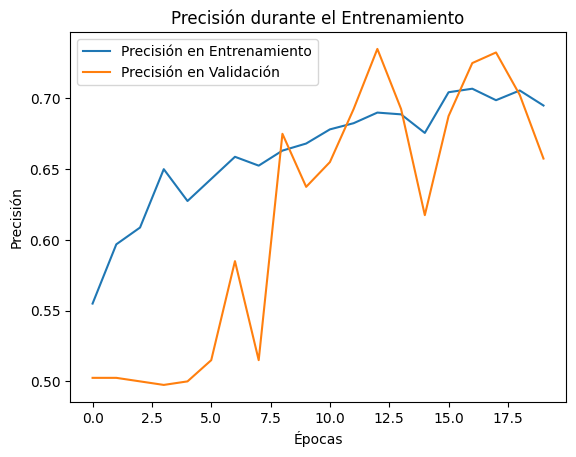

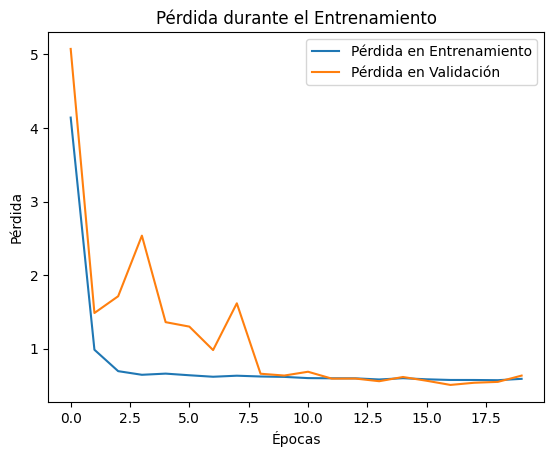

In [38]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()


# Guardar el modelo

In [37]:
# Guardar el modelo
model.save("final_model.h5")
print("Modelo guardado como 'final_model.h5'.")


Modelo guardado como 'final_model.h5'.
